# Machine Learning Project 1: Perceptron, Adaline, SVM, and Logistic Regression


In this project, we will be analyzing the adult.csv dataset to predict and classify income based on demographic and life experience variables. The objective is to practically apply the machine learning algorithms and optimization techniques covered in class to a real-world dataset. 

Import the necessary packages:

In [32]:
import pandas as pd 
import numpy as np 
from scipy import sparse as sp
from sklearn.pipeline import Pipeline 
from sklearn.preprocessing import OneHotEncoder, StandardScaler 
from sklearn.compose import ColumnTransformer 
from sklearn.impute import SimpleImputer 
from sklearn import set_config 
from sklearn.linear_model import Perceptron, SGDRegressor
from sklearn.metrics import mean_squared_error, accuracy_score
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
import os
from itertools import combinations
from matplotlib.backends.backend_pdf import PdfPages

Load in the data:

In [33]:
train_df = pd.read_csv("project_adult.csv")
validation_df = pd.read_csv("project_validation_inputs.csv")

Perform basic data cleaning:

In [34]:
# RENAME THE FIRST COLUMN:
train_df = train_df.rename(columns={"Unnamed: 0": "index"})
validation_df = validation_df.rename(columns={"Unnamed: 0": "index"})

# CLEAN THE DATA:
def basic_clean(df):
    # standardize column names
    df.columns = (
        df.columns
            .str.strip() # remove leading/trailing spaces
            .str.lower() # convert to lowercase
            .str.replace(" ", "_") # replace spaces with underscore
            .str.replace("-", "_") # replace hyphens with underscore
    )
    df = df.replace("?", np.nan) # replace "?" with NaN within data
    # clean data within columns
    for col in df.select_dtypes(include="object").columns:
        df[col] = df[col].str.lower()# convert to lowercase
        df[col] = df[col].str.strip() # remove leading/trailing spaces
        df[col] = df[col].str.replace("-", "_") # replace hyphens with underscore
    return df

# NORMALIZE INCOME LABELS:
train_df["income"] = train_df["income"].str.strip()
# adjust income values to be binary
    # GREATER THAN OR EQUAL TO 50K = 0
    # LESS THAN 50K = 1
train_df["income"] = train_df["income"].replace({
    "<=50K": 0, "<=50K.": 0,
    ">50K": 1,  ">50K.": 1
})

/var/folders/r0/yspt3b392t7155kd4jscsq4c0000gn/T/ipykernel_1868/196705499.py:28: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  train_df["income"] = train_df["income"].replace({


In [35]:
# APPLY THE CLEANING FUNCTION:
train_df = basic_clean(train_df)
validation_df = basic_clean(validation_df)

EDA:

In [36]:
# SHAPE
print("Train shape:", train_df.shape)
print("Validation shape:", validation_df.shape)

Train shape: (26048, 16)
Validation shape: (6513, 15)


In [37]:
train_df

,index,age,workclass,fnlwgt,education,education_num,marital_status,occupation,relationship,race,sex,capital_gain,capital_loss,hours_per_week,native_country,income
0,5514,33,local_gov,198183,bachelors,13,never_married,prof_specialty,not_in_family,white,female,0,0,50,united_states,1
1,19777,36,private,86459,assoc_voc,11,married_civ_spouse,exec_managerial,husband,white,male,0,1887,50,united_states,1
2,10781,58,self_emp_not_inc,203039,9th,5,separated,craft_repair,not_in_family,white,male,0,0,40,united_states,0
3,32240,21,private,180190,assoc_voc,11,married_civ_spouse,farming_fishing,husband,white,male,0,0,46,united_states,0
4,9876,27,private,279872,some_college,10,divorced,other_service,not_in_family,white,male,0,0,40,united_states,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
26043,29802,47,private,359461,bachelors,13,married_civ_spouse,craft_repair,husband,white,male,0,0,40,united_states,0
26044,5390,31,private,147215,12th,8,divorced,other_service,unmarried,white,female,0,0,21,united_states,0
26045,860,18,private,216284,11th,7,never_married,adm_clerical,own_child,white,female,0,0,20,united_states,0
26046,15795,50,self_emp_not_inc,54261,hs_grad,9,married_civ_spouse,farming_fishing,husband,white,male,0,0,84,united_states,0


In [38]:
# print number of NAs in training data
print("\nMissing count per variable in training data:")
print(train_df.isna().sum())


Missing count per variable in training data:
index                0
age                  0
workclass         1447
fnlwgt               0
education            0
education_num        0
marital_status       0
occupation        1454
relationship         0
race                 0
sex                  0
capital_gain         0
capital_loss         0
hours_per_week       0
native_country     458
income               0
dtype: int64


In [39]:
# print number of NAs in validation data
print("\nMissing count per variable in validation data:")
print(validation_df.isna().sum())


Missing count per variable in validation data:
index               0
age                 0
workclass         389
fnlwgt              0
education           0
education_num       0
marital_status      0
occupation        389
relationship        0
race                0
sex                 0
capital_gain        0
capital_loss        0
hours_per_week      0
native_country    125
dtype: int64


In [40]:
# count each class and normalize to percentage
income_counts = train_df["income"].value_counts(normalize=True) * 100

print(income_counts)

income
0    75.929054
1    24.070946
Name: proportion, dtype: float64


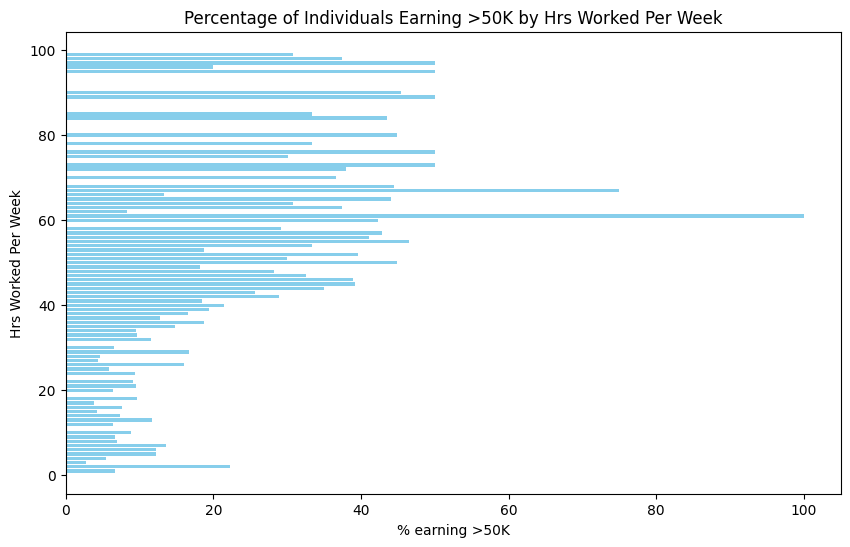

In [41]:
# calculate % earning >50K per hours per week
hours_income = (
    train_df.groupby(["hours_per_week"])["income"]
            .mean()
            .reset_index()
)

# convert proportions to percentages
hours_income["income"] = hours_income["income"] * 100

# plot
plt.figure(figsize=(10,6))
plt.barh(hours_income["hours_per_week"], hours_income["income"], color="skyblue")

plt.xlabel("% earning >50K")
plt.ylabel("Hrs Worked Per Week")
plt.title("Percentage of Individuals Earning >50K by Hrs Worked Per Week")
plt.show()

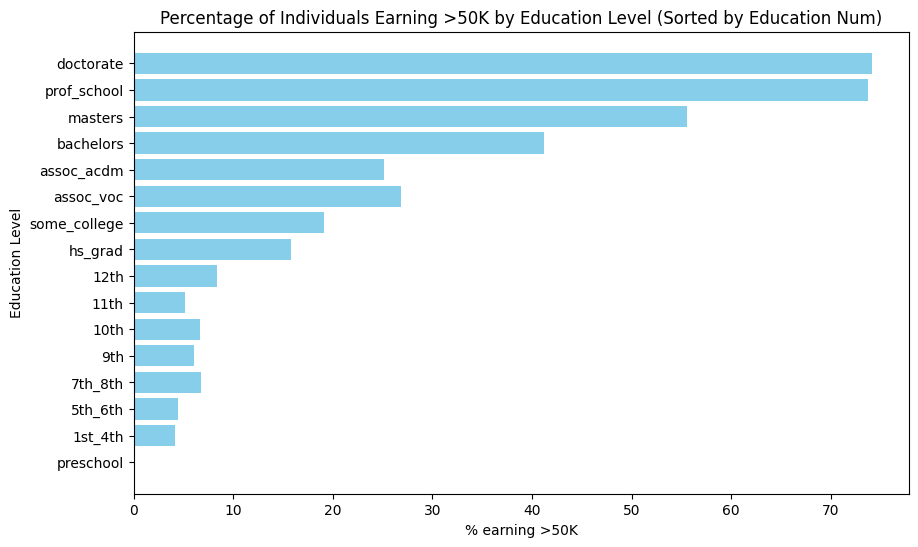

In [42]:
# calculate % earning >50K per education level
edu_income = (
    train_df.groupby(["education", "education_num"])["income"]
            .mean()
            .reset_index()
            .sort_values("education_num")  # sort by numeric education level
)

# convert proportions to percentages
edu_income["income"] = edu_income["income"] * 100

# plot
plt.figure(figsize=(10,6))
plt.barh(edu_income["education"], edu_income["income"], color="skyblue")

plt.xlabel("% earning >50K")
plt.ylabel("Education Level")
plt.title("Percentage of Individuals Earning >50K by Education Level (Sorted by Education Num)")
plt.show()

In [43]:
# explore prevalance of age groups:

# group ages by decade 
age_counts_by_decade = (
    train_df.groupby((train_df["age"] // 10) * 10)  # integer division → 10s, 20s, 30s, etc.
            .size()
            .reset_index(name="count")
            .rename(columns={"age": "age_decade"})  # rename column for clarity
            .sort_values("age_decade")
)

print(age_counts_by_decade.to_string(index=False))


 age_decade  count
         10   1322
         20   6450
         30   6895
         40   5765
         50   3473
         60   1634
         70    416
         80     59
         90     34


In [44]:
# show each level of education, the number associated with it, and count of each for better understanding
edu_counts = (
    train_df.groupby(["education_num", "education"])
            .size()                               # counts
            .reset_index(name="count")            # put into a column
            .sort_values("education_num")         # orders by the numeric code
)

#print
print(edu_counts.to_string(index=False))

 education_num    education  count
             1    preschool     41
             2      1st_4th    145
             3      5th_6th    271
             4      7th_8th    505
             5          9th    399
             6         10th    750
             7         11th    950
             8         12th    335
             9      hs_grad   8416
            10 some_college   5806
            11    assoc_voc   1109
            12   assoc_acdm    869
            13    bachelors   4302
            14      masters   1354
            15  prof_school    460
            16    doctorate    336


Encoding Categorical Values:

In [45]:
# separate target from features (TRAIN ONLY)
y_train = train_df["income"] # target
X_train = train_df.drop(columns=["income"])

In [46]:
# IDENTIFY COLUMN TYPES: 
categorical_cols = X_train.select_dtypes(include=["object"]).columns
numerical_cols = X_train.select_dtypes(include=["int64", "float64"]).columns

# print
print("Categorical columns:", categorical_cols.tolist())
print("Numerical columns:", numerical_cols.tolist())

Categorical columns: ['workclass', 'education', 'marital_status', 'occupation', 'relationship', 'race', 'sex', 'native_country']
Numerical columns: ['index', 'age', 'fnlwgt', 'education_num', 'capital_gain', 'capital_loss', 'hours_per_week']


In [47]:
# DEFINE TRANSFORMERS (processing steps):

"""
Here we are going to simply impute the missing values with median and mode values. 
In practice, this can be problematic, as we are assuming values to be MAR (missing at random), 
which is not always the case. More sophisticated methods can be used, 
but for simplicity we will use this approach.
"""

categorical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")), # fill NaN with most common
    ("onehot", OneHotEncoder(handle_unknown="ignore"))
])

numerical_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="median")), # fill NaN with median
    ("scaler", StandardScaler()) # standardize
])

In [48]:
# COMBINE INTO PREPROCESSER
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numerical_transformer, numerical_cols),
        ("cat", categorical_transformer, categorical_cols)
    ]
)

In [49]:
# FIT ON TRAINING, TRANSFORM BOTH
X_train_processed = preprocessor.fit_transform(X_train)
X_validation_processed = preprocessor.transform(validation_df)

print("Processed training shape:", X_train_processed.shape)
print("Processed validation shape:", X_validation_processed.shape)

Processed training shape: (26048, 106)
Processed validation shape: (6513, 106)


In [50]:
# CHECK FOR NAs:
def has_nan_or_inf(X):
    data = X.data if sp.issparse(X) else X
    return np.isnan(data).any(), np.isinf(data).any()

print("Train processed:  NA/Inf:", has_nan_or_inf(X_train_processed))
print("Validation processed:  NA/Inf:", has_nan_or_inf(X_validation_processed))

Train processed:  NA/Inf: (np.False_, np.False_)
Validation processed:  NA/Inf: (np.False_, np.False_)


# Perceptron and Adaline Modelling

In [51]:
N_EPOCHS  = 30       # how many passes through the training set
THRESH    = 0.5      # Adaline threshold to turn raw scores into 0/1 class labels
RNG_BASE  = 123      # seed base for reproducible shuffles
# -------------------------------------------------------------------------


# ---------- inputs from your preprocessing ----------
Xtr_full = X_train_processed                     # features (already processed)
ytr_full = pd.Series(y_train).astype(int).values # labels as ints {0,1}
classes   = np.array([0, 1])                     # needed by Perceptron on first partial_fit
# sanity check
assert set(np.unique(ytr_full)).issubset({0,1}), "y_train must be binary {0,1}"



In [52]:
class Custom_Perceptron:
    """Perceptron classifier (sparse-safe)."""

    def __init__(self, eta=0.01, n_iter=50, random_state=42):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state
        
    def _row_to_dense(self, x):
        return x.toarray().ravel() if sp.issparse(x) else np.asarray(x).ravel()

    def _net_input_vec(self, X):
        if sp.issparse(X):
            z = X @ self.w_
            z = np.asarray(z).ravel()
        else:
            X = np.asarray(X)
            z = X @ self.w_
            if np.isscalar(z) or z.ndim == 0:
                z = np.array([z])
        return z + self.b_

    def net_input(self, X):
        if sp.issparse(X) or (hasattr(X, "ndim") and getattr(X, "ndim", 1) == 2):
            z = self._net_input_vec(X)
            return z if z.size > 1 else float(z[0])
        else:
            x = np.asarray(X).ravel()
            return float(x @ self.w_ + self.b_)
        
    def predict(self, X):
        z = self.net_input(X)
        if np.isscalar(z):
            return int(z >= 0.0)
        out = (z >= 0.0).astype(int)
        return out

    def fit(self, X, y):
        y = np.asarray(y).astype(int)
        assert set(np.unique(y)).issubset({0, 1})

        rgen = np.random.RandomState(self.random_state)
        n_features = X.shape[1]
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=n_features)
        self.b_ = np.float64(0.0)

        self.errors_ = []
        self.train_mis_ = []       # track misclassifications after each epoch
        self.snapshots_ = []       # store weights/bias for rollback

        for _ in range(self.n_iter):
            errors = 0
            for xi, target in zip(X, y):
                xi = self._row_to_dense(xi)
                yhat = 1 if (xi @ self.w_ + self.b_) >= 0.0 else 0
                update = self.eta * (target - yhat)
                if update != 0.0:
                    self.w_ += update * xi
                    self.b_ += update
                    errors += 1
            self.errors_.append(int(errors))

            # misclassifications on training set (post-epoch)
            yhat_epoch = self.predict(X)
            mis = int(np.sum(yhat_epoch != y))
            self.train_mis_.append(mis)

            # snapshot weights & bias
            self.snapshots_.append((self.w_.copy(), float(self.b_)))

        # choose best epoch = fewest misclassifications
        self.best_epoch_ = int(np.argmin(self.train_mis_)) + 1
        self.best_w_, self.best_b_ = self.snapshots_[self.best_epoch_ - 1]

        return self

    def restore_best(self):
        """restore weights from the best epoch"""
        self.w_ = self.best_w_.copy()
        self.b_ = float(self.best_b_)


Best epoch: 10


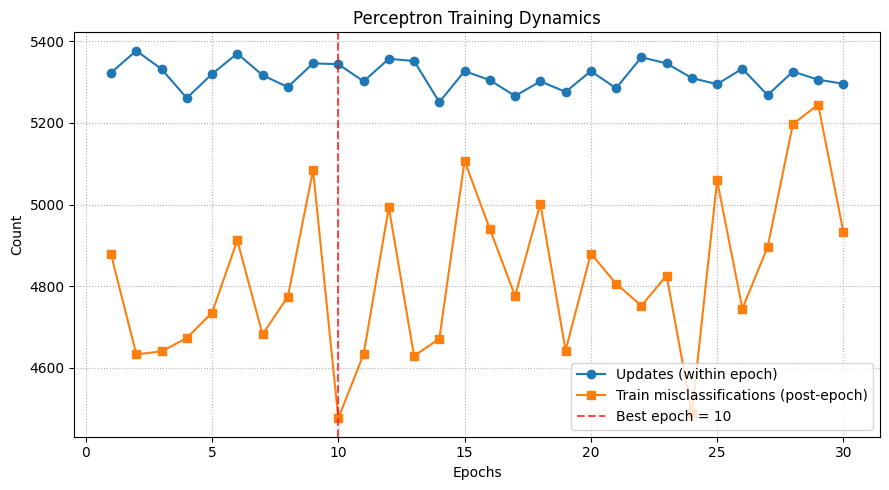

In [23]:
# after fitting
cust_ppn = Custom_Perceptron(eta=0.1, n_iter=30, random_state=42)
cust_ppn.fit(Xtr_full, ytr_full)

print("Best epoch:", cust_ppn.best_epoch_)

# --- Plot ---
epochs = range(1, len(cust_ppn.errors_) + 1)

plt.figure(figsize=(9,5))
plt.plot(epochs, cust_ppn.errors_, marker='o', label='Updates (within epoch)')
plt.plot(epochs, cust_ppn.train_mis_, marker='s', label='Train misclassifications (post-epoch)')

# highlight best epoch
be = cust_ppn.best_epoch_
plt.axvline(be, linestyle='--', color='red', alpha=0.7, label=f'Best epoch = {be}')

plt.xlabel("Epochs")
plt.ylabel("Count")
plt.title("Perceptron Training Dynamics")
plt.legend()
plt.grid(True, linestyle=':')
plt.tight_layout()
plt.show()


In [24]:
cust_ppn = Custom_Perceptron(eta=0.1, n_iter=30, random_state=42)
cust_ppn.fit(Xtr_full, ytr_full)

print("Best epoch:", cust_ppn.best_epoch_)
print("Training misclassifications at best epoch:", cust_ppn.train_mis_[cust_ppn.best_epoch_-1])

# restore the weights from that best epoch
cust_ppn.restore_best()

# accuracy
acc = accuracy_score(ytr_full, cust_ppn.predict(Xtr_full))

print(f"Training accuracy at best epoch: {acc:.4f}")


Best epoch: 10
Training misclassifications at best epoch: 4476
Training accuracy at best epoch: 0.8282


In [25]:
class Custom_AdalineGD:
    """ADAptive LInear NEuron classifier.

    Parameters
    ------------
    eta : float
      Learning rate (between 0.0 and 1.0)
    n_iter : int
      Passes over the training dataset.
    random_state : int
      Random number generator seed for random weight
      initialization.


    Attributes
    -----------
    w_ : 1d-array
      Weights after fitting.
    b_ : Scalar
      Bias unit after fitting.
    losses_ : list
      Mean squared eror loss function values in each epoch.

    """
    def __init__(self, eta=0.01, n_iter=50, random_state=1):
        self.eta = eta
        self.n_iter = n_iter
        self.random_state = random_state

    def fit(self, X, y):
        """ Fit training data.

        Parameters
        ----------
        X : {array-like}, shape = [n_examples, n_features]
          Training vectors, where n_examples is the number of examples and
          n_features is the number of features.
        y : array-like, shape = [n_examples]
          Target values.

        Returns
        -------
        self : object

        """
        rgen = np.random.RandomState(self.random_state)
        self.w_ = rgen.normal(loc=0.0, scale=0.01, size=X.shape[1])
        self.b_ = np.float64(0.)
        self.losses_ = []

        for i in range(self.n_iter):
            net_input = self.net_input(X)
            # Please note that the "activation" method has no effect
            # in the code since it is simply an identity function. We
            # could write `output = self.net_input(X)` directly instead.
            # The purpose of the activation is more conceptual, i.e.,  
            # in the case of logistic regression (as we will see later), 
            # we could change it to
            # a sigmoid function to implement a logistic regression classifier.
            output = self.activation(net_input)
            errors = (y - output)          
            self.w_ += self.eta * 2.0 * X.T.dot(errors) / X.shape[0]
            self.b_ += self.eta * 2.0 * errors.mean()
            loss = (errors**2).mean()
            self.losses_.append(loss)
        return self

    def net_input(self, X):
        """Calculate net input"""
        return np.dot(X, self.w_) + self.b_

    def activation(self, X):
        """Compute linear activation"""
        return X

    def predict(self, X):
        """Return class label after unit step"""
        return np.where(self.activation(self.net_input(X)) >= 0.5, 1, 0)
      
      
      

      
      


[AdalineGD] Best epoch by TRAIN MSE: 30 (MSE=0.135291)


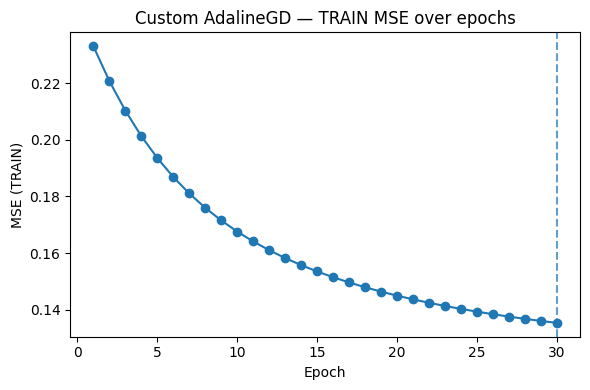

[AdalineGD] TRAIN acc (epoch 30): 0.7833 | miscls=5645
[AdalineGD] Validation predictions ready: shape=(6513,)


In [26]:
# --- robust orientation + prediction for your Custom_AdalineGD run ---


# ---------------- config ----------------
N_EPOCHS = 30
ETA_ADAL = 0.01
RNG_BASE = 123

# ---------------- inputs ----------------
Xtr_full = X_train_processed
ytr_full = pd.Series(y_train).astype(int).values

# choose validation source
Xval_full = X_validation_processed if 'X_validation_processed' in globals() else project_validation_inputs

# sanity
assert set(np.unique(ytr_full)).issubset({0, 1}), "y_train must be binary {0,1}"

# ---------------- orientation helper ----------------
def ensure_samples_by_features(X, n_features):
    """
    Return X with shape (n_samples, n_features).
    If X is (n_features, n_samples), transpose it.
    Works for dense and sparse. Raises if neither dim matches n_features.
    """
    if sp.issparse(X):
        r, c = X.shape
        if c == n_features:
            return X
        if r == n_features:
            return X.T
        raise ValueError(f"Validation matrix shape {X.shape} incompatible with n_features={n_features}")
    else:
        X = np.asarray(X)
        if X.ndim == 1:
            # single sample vector
            if X.size == n_features:
                return X.reshape(1, -1)
            raise ValueError(f"1-D validation vector length {X.size} != n_features={n_features}")
        r, c = X.shape
        if c == n_features:
            return X
        if r == n_features:
            return X.T
        raise ValueError(f"Validation matrix shape {X.shape} incompatible with n_features={n_features}")

# ---------------- patch: sparse-safe net_input ----------------
def _net_input_sparse_safe(self, X):
    if sp.issparse(X):
        z = X @ self.w_
        z = np.asarray(z).ravel()
        return z + self.b_
    else:
        z = np.dot(X, self.w_)
        # ensure 1-D output for batch; scalar for single sample
        return (z + self.b_)
Custom_AdalineGD.net_input = _net_input_sparse_safe

# ---------------- prep data (train + val) ----------------
# Fix train orientation
if Xtr_full.shape[0] != ytr_full.shape[0] and Xtr_full.shape[1] == ytr_full.shape[0]:
    Xtr_full = Xtr_full.T  # flip to (n_samples, n_features)
n_features = Xtr_full.shape[1]

# Fix val orientation to match training features
Xval_fixed = ensure_samples_by_features(Xval_full, n_features)

# ---------------- train (full run for curve) ----------------
adal_full = Custom_AdalineGD(
    eta=ETA_ADAL, n_iter=N_EPOCHS, random_state=RNG_BASE
).fit(Xtr_full, ytr_full)

best_ep_adal = int(np.argmin(adal_full.losses_)) + 1
print(f"[AdalineGD] Best epoch by TRAIN MSE: {best_ep_adal} (MSE={adal_full.losses_[best_ep_adal-1]:.6f})")

# plot curve
plt.figure(figsize=(6,4))
plt.plot(range(1, N_EPOCHS+1), adal_full.losses_, marker='o')
plt.axvline(best_ep_adal, linestyle='--', alpha=0.7)
plt.xlabel("Epoch"); plt.ylabel("MSE (TRAIN)")
plt.title("Custom AdalineGD — TRAIN MSE over epochs")
plt.tight_layout(); plt.show()

# ---------------- retrain to best epoch ----------------
adal_best = Custom_AdalineGD(
    eta=ETA_ADAL, n_iter=best_ep_adal, random_state=RNG_BASE
).fit(Xtr_full, ytr_full)

# TRAIN metrics
yhat_tr = adal_best.predict(Xtr_full).astype(int)
train_acc = (yhat_tr == ytr_full).mean()
miscls = int((yhat_tr != ytr_full).sum())
print(f"[AdalineGD] TRAIN acc (epoch {best_ep_adal}): {train_acc:.4f} | miscls={miscls}")

# ---------------- validation predictions ----------------
val_pred_adal = adal_best.predict(Xval_fixed).astype(int)
print(f"[AdalineGD] Validation predictions ready: shape={val_pred_adal.shape}")


# SKLearn Perceptron and Adaline

Best Perceptron epoch by TRAIN misclassifications: 14 (miscls=4299)
Best Adaline   epoch by TRAIN MSE:                23 (MSE=0.115943)


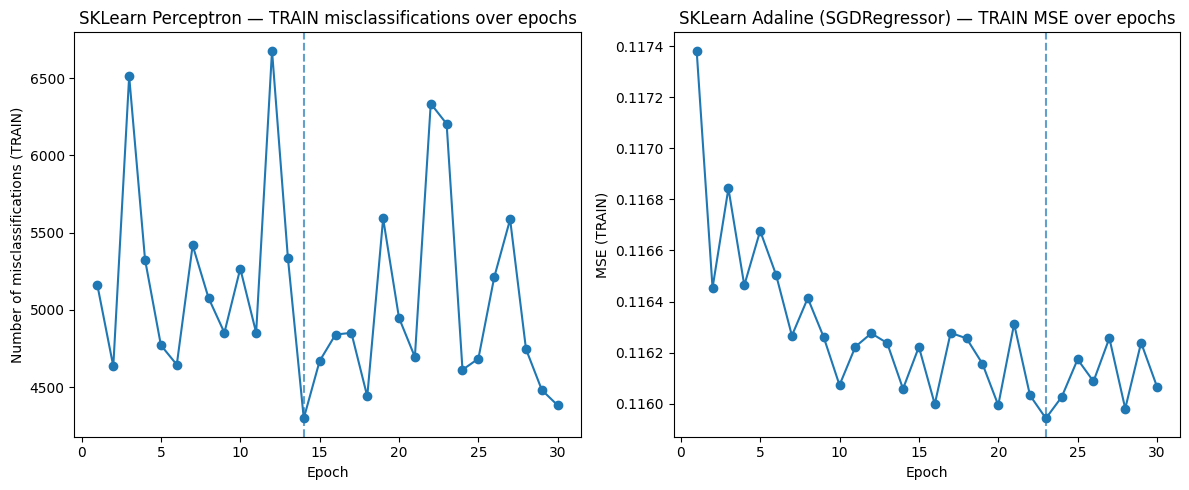

Perceptron (chosen epoch 14) TRAIN accuracy: 0.8198  miscls=4694
Adaline   (chosen epoch 23) TRAIN accuracy: 0.8404  miscls=4156 (threshold=0.5)


In [27]:
# ---------- build fresh models (1-epoch-per-partial_fit) ----------
perc = Perceptron(max_iter=1, tol=None, random_state=42)
adal = SGDRegressor(loss="squared_error", max_iter=1, tol=None, random_state=42)

# storage for learning curves
perc_mis_per_epoch  = []  # number of misclassifications on TRAIN
adal_mse_per_epoch  = []  # MSE on TRAIN

# ---------- training loop across epochs (FULL training set) ----------
for epoch in range(N_EPOCHS):
    # shuffle order each epoch — same data, different pass order
    order = np.random.RandomState(RNG_BASE + epoch).permutation(len(ytr_full))
    Xe, ye = Xtr_full[order], ytr_full[order]

    # Perceptron one more epoch of learning
    if epoch == 0:
        perc.partial_fit(Xe, ye, classes=classes)
    else:
        perc.partial_fit(Xe, ye)

    # Adaline one more epoch of learning (SGD on squared loss)
    if epoch == 0:
        adal.partial_fit(Xe, ye)
    else:
        adal.partial_fit(Xe, ye)

    # ---- metrics on FULL training set (what the spec asks to plot) ----
    # Perceptron: number of misclassifications
    yhat_p = perc.predict(Xtr_full)
    mis_p  = int((yhat_p != ytr_full).sum())
    perc_mis_per_epoch.append(mis_p)

    # Adaline: mean squared error on raw outputs
    yhat_a_raw = adal.predict(Xtr_full)
    mse_a      = mean_squared_error(ytr_full, yhat_a_raw)
    adal_mse_per_epoch.append(mse_a)

# ---------- choose best epochs by the required TRAIN metrics ----------
best_ep_perc = int(np.argmin(perc_mis_per_epoch)) + 1  # +1 -> human-friendly (1..N)
best_ep_adal = int(np.argmin(adal_mse_per_epoch)) + 1

print(f"Best Perceptron epoch by TRAIN misclassifications: {best_ep_perc} "
      f"(miscls={perc_mis_per_epoch[best_ep_perc-1]})")
print(f"Best Adaline   epoch by TRAIN MSE:                {best_ep_adal} "
      f"(MSE={adal_mse_per_epoch[best_ep_adal-1]:.6f})")

# ---------- plot learning curves (TRAIN vs epoch) ----------
plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(range(1, N_EPOCHS+1), perc_mis_per_epoch, marker='o')
plt.axvline(best_ep_perc, linestyle='--', alpha=0.7)
plt.xlabel("Epoch")
plt.ylabel("Number of misclassifications (TRAIN)")
plt.title("SKLearn Perceptron — TRAIN misclassifications over epochs")

plt.subplot(1,2,2)
plt.plot(range(1, N_EPOCHS+1), adal_mse_per_epoch, marker='o')
plt.axvline(best_ep_adal, linestyle='--', alpha=0.7)
plt.xlabel("Epoch")
plt.ylabel("MSE (TRAIN)")
plt.title("SKLearn Adaline (SGDRegressor) — TRAIN MSE over epochs")

plt.tight_layout()
plt.show()

# ---------- retrain FRESH models up to best epochs on FULL training ----------
perc_final = Perceptron(max_iter=1, tol=None, random_state=42)
try:
    adal_final = SGDRegressor(loss="squared_error", max_iter=1, tol=None, random_state=42)
except TypeError:
    adal_final = SGDRegressor(loss="squared_loss", max_iter=1, tol=None, random_state=42)

for e in range(best_ep_perc):
    if e == 0: perc_final.partial_fit(Xtr_full, ytr_full, classes=classes)
    else:      perc_final.partial_fit(Xtr_full, ytr_full)

for e in range(best_ep_adal):
    if e == 0: adal_final.partial_fit(Xtr_full, ytr_full)
    else:      adal_final.partial_fit(Xtr_full, ytr_full)


# ---------- report TRAIN accuracy of the chosen models ----------
yhat_perc_train = perc_final.predict(Xtr_full)
train_acc_perc  = accuracy_score(ytr_full, yhat_perc_train)
miscls_perc     = int((yhat_perc_train != ytr_full).sum())

yhat_adal_train = (adal_final.predict(Xtr_full) >= THRESH).astype(int)
train_acc_adal  = accuracy_score(ytr_full, yhat_adal_train)
miscls_adal     = int((yhat_adal_train != ytr_full).sum())

print(f"Perceptron (chosen epoch {best_ep_perc}) "
      f"TRAIN accuracy: {train_acc_perc:.4f}  "
      f"miscls={miscls_perc}")
print(f"Adaline   (chosen epoch {best_ep_adal}) "
      f"TRAIN accuracy: {train_acc_adal:.4f}  "
      f"miscls={miscls_adal} (threshold={THRESH})")



# Logistic Regression and SVM

In [28]:
# inputs!!!
Xtr_full = X_train_processed
ytr_full = pd.Series(y_train).astype(int).values
assert set(np.unique(ytr_full)).issubset({0, 1}), "y_train must be binary {0,1}"

# sweep C and track TRAIN accuracy
C_GRID = [0.01, 1.0, 100.0]
MAX_ITERS = 10000

lr_results  = []
svm_results = []

for C in C_GRID:
    lr = LogisticRegression(C=C, penalty="l2", solver="lbfgs", max_iter=MAX_ITERS, random_state=42)
    lr.fit(Xtr_full, ytr_full)
    lr_acc = accuracy_score(ytr_full, lr.predict(Xtr_full))
    lr_results.append((C, lr_acc, lr))

    svm = LinearSVC(C=C, random_state=42, max_iter=MAX_ITERS)
    svm.fit(Xtr_full, ytr_full)
    svm_acc = accuracy_score(ytr_full, svm.predict(Xtr_full))
    svm_results.append((C, svm_acc, svm))

# choose best by TRAIN accuracy
best_lr_C, best_lr_acc,  lr_final  = max(lr_results,  key=lambda x: x[1])
best_svm_C, best_svm_acc, svm_final = max(svm_results, key=lambda x: x[1])

print("Logistic Regression (TRAIN acc by C):")
for C, acc, _ in lr_results:
    miscls = (lr_results[C_GRID.index(C)][2].predict(Xtr_full) != ytr_full).sum()
    print(f"  C={C:<7} acc={acc:.4f}  miscls={miscls}")
print(f"--> Best LR C={best_lr_C}  TRAIN acc={best_lr_acc:.4f}\n")

print("Linear SVM (TRAIN acc by C):")
for C, acc, _ in svm_results:
    miscls = (svm_results[C_GRID.index(C)][2].predict(Xtr_full) != ytr_full).sum()
    print(f"  C={C:<7} acc={acc:.4f}  miscls={miscls}")
print(f"--> Best SVM C={best_svm_C} TRAIN acc={best_svm_acc:.4f}")


Logistic Regression (TRAIN acc by C):
  C=0.01    acc=0.8480  miscls=3959
  C=1.0     acc=0.8514  miscls=3871
  C=100.0   acc=0.8517  miscls=3864
--> Best LR C=100.0  TRAIN acc=0.8517

Linear SVM (TRAIN acc by C):
  C=0.01    acc=0.8512  miscls=3875
  C=1.0     acc=0.8519  miscls=3858
  C=100.0   acc=0.8517  miscls=3862
--> Best SVM C=1.0 TRAIN acc=0.8519


In [29]:
# Perceptron
pd.DataFrame({"pred": perc_final.predict(X_validation_processed)}).to_csv(
    "Group_11_Perceptron_PredictedOutputs.csv", index=False
)

# Adaline (binarize raw score at 0.5)
pd.DataFrame({"pred": (adal_final.predict(X_validation_processed) >= 0.5).astype(int)}).to_csv(
    "Group_11_Adaline_PredictedOutputs.csv", index=False
)

# Logistic Regression
pd.DataFrame({"pred": lr_final.predict(X_validation_processed)}).to_csv(
    "Group_11_LogisticRegression_PredictedOutputs.csv", index=False
)

# Linear SVM
pd.DataFrame({"pred": svm_final.predict(X_validation_processed)}).to_csv(
    "Group_11_SVM_PredictedOutputs.csv", index=False
)



In [30]:
def plot_svm_all_pairs(
    train_df: pd.DataFrame,
    y_train,
    C=None,
    max_iter=2000,
    mesh_pts=300,
    random_state=42,
    figsize=(6,5),
    save_dir=None,           # e.g. "svm_pairwise_plots"
    save_pdf_path=None,      # e.g. "svm_pairwise_plots.pdf"
    dpi=150,
    max_pairs=None           # limit if there are tons of pairs
):
    """
    Make one figure per numeric feature pair (LinearSVC boundary). Easy to scroll.

    - If save_dir is set: saves each figure as a PNG.
    - If save_pdf_path is set: also saves all figures into a single multi-page PDF.
    - If neither is set: just shows figures (you can scroll the output).
    """
    if C is None:
        C = globals().get("best_svm_C", 1.0)

    num_cols = train_df.select_dtypes(include="number").columns.tolist()
    if len(num_cols) < 2:
        raise ValueError("Need at least two numeric columns.")

    pairs = list(combinations(num_cols, 2))
    if max_pairs is not None:
        pairs = pairs[:max_pairs]

    # prepare labels
    y_series = pd.Series(y_train)
    # handle multiclass by mapping top-2 classes to 0/1
    unique_vals = y_series.dropna().unique()
    binarized_note = False
    y_map = None
    if len(unique_vals) > 2:
        top2 = y_series.value_counts().index[:2].tolist()
        y_map = {top2[0]: 0, top2[1]: 1}
        binarized_note = True

    if save_dir is not None:
        os.makedirs(save_dir, exist_ok=True)

    pdf = PdfPages(save_pdf_path) if save_pdf_path else None

    for idx, (fx, fy) in enumerate(pairs, start=1):
        # join and drop NaNs
        df_xy = train_df[[fx, fy]].join(y_series.rename("_y")).dropna()
        if df_xy.empty:
            # make a small placeholder figure so you see which pair was skipped
            fig, ax = plt.subplots(figsize=figsize)
            ax.set_title(f"[{idx}/{len(pairs)}] {fx} vs {fy}")
            ax.text(0.5, 0.5, "Skipped: all rows NaN after filtering.", ha="center")
            ax.set_xticks([]); ax.set_yticks([])
            _finalize(fig, save_dir, pdf, dpi, fx, fy)
            plt.close(fig)
            continue

        y2 = df_xy["_y"]
        if y_map is not None:
            y2 = y2.where(y2.isin(y_map))
            df_xy = df_xy.loc[y2.notna()]
            if df_xy.empty:
                fig, ax = plt.subplots(figsize=figsize)
                ax.set_title(f"[{idx}/{len(pairs)}] {fx} vs {fy}")
                ax.text(0.5, 0.5, "Skipped: no rows in top-2 classes.", ha="center")
                ax.set_xticks([]); ax.set_yticks([])
                _finalize(fig, save_dir, pdf, dpi, fx, fy)
                plt.close(fig)
                continue
            y2 = y2.loc[df_xy.index].map(y_map).astype(int)
        else:
            y2 = pd.Series(y2).astype(int)

        if y2.nunique() < 2:
            fig, ax = plt.subplots(figsize=figsize)
            ax.set_title(f"[{idx}/{len(pairs)}] {fx} vs {fy}")
            ax.text(0.5, 0.5, "Skipped: only one class present.", ha="center")
            ax.set_xticks([]); ax.set_yticks([])
            _finalize(fig, save_dir, pdf, dpi, fx, fy)
            plt.close(fig)
            continue

        X2 = df_xy[[fx, fy]].values

        # scale and fit
        scaler = StandardScaler()
        X2s = scaler.fit_transform(X2)
        clf = LinearSVC(C=C, random_state=random_state, max_iter=max_iter)
        try:
            clf.fit(X2s, y2.values)
        except Exception as e:
            fig, ax = plt.subplots(figsize=figsize)
            ax.set_title(f"[{idx}/{len(pairs)}] {fx} vs {fy}")
            ax.text(0.5, 0.5, f"Fit failed: {e}", ha="center")
            ax.set_xticks([]); ax.set_yticks([])
            _finalize(fig, save_dir, pdf, dpi, fx, fy)
            plt.close(fig)
            continue

        # mesh + predict
        x_min, x_max = X2s[:,0].min()-1, X2s[:,0].max()+1
        y_min, y_max = X2s[:,1].min()-1, X2s[:,1].max()+1
        xx, yy = np.meshgrid(
            np.linspace(x_min, x_max, mesh_pts),
            np.linspace(y_min, y_max, mesh_pts)
        )
        try:
            Z = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
        except Exception as e:
            fig, ax = plt.subplots(figsize=figsize)
            ax.set_title(f"[{idx}/{len(pairs)}] {fx} vs {fy}")
            ax.text(0.5, 0.5, f"Predict failed: {e}", ha="center")
            ax.set_xticks([]); ax.set_yticks([])
            _finalize(fig, save_dir, pdf, dpi, fx, fy)
            plt.close(fig)
            continue

        # plot
        fig, ax = plt.subplots(figsize=figsize)
        ax.contourf(xx, yy, Z, alpha=0.2, levels=[-0.5, 0.5, 1.5])
        ax.scatter(X2s[:,0], X2s[:,1], c=y2.values, s=10, alpha=0.85)
        title = f"[{idx}/{len(pairs)}] Linear SVM: {fx} vs {fy}"
        if binarized_note:
            title += "  (binarized to top-2 classes)"
        ax.set_title(title)
        ax.set_xlabel(f"{fx} (scaled)")
        ax.set_ylabel(f"{fy} (scaled)")
        plt.tight_layout()

        # save/show
        _finalize(fig, save_dir, pdf, dpi, fx, fy)
        # leave figure open if not saving so you can scroll
        if save_dir or pdf:
            plt.close(fig)

    if pdf:
        pdf.close()

def _finalize(fig, save_dir, pdf, dpi, fx, fy):
    if save_dir:
        fname = f"svm_boundary_{fx}__vs__{fy}.png".replace("/", "-")
        fig.savefig(os.path.join(save_dir, fname), dpi=dpi)
    if pdf:
        pdf.savefig(fig)
    if not save_dir and not pdf:
        plt.show()

# EXAMPLE:
# plot_svm_all_pairs(train_df, y_train,
#                    C=best_svm_C if "best_svm_C" in globals() else 1.0,
#                    save_dir=None,                 # set a folder to save PNGs
#                    save_pdf_path=None,            # or set a path to save one PDF
#                    max_pairs=None)                # or limit to a subset


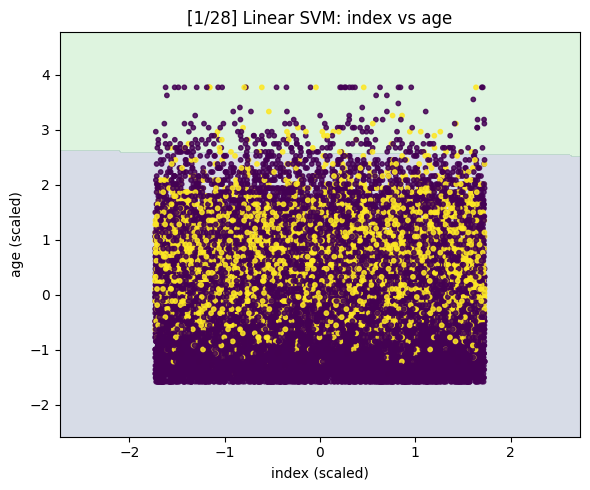

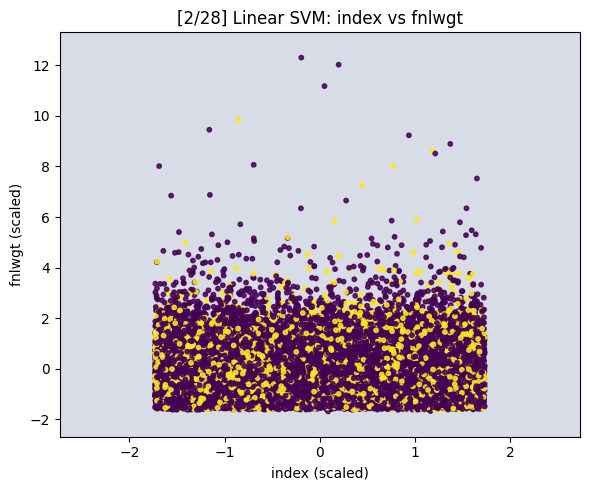

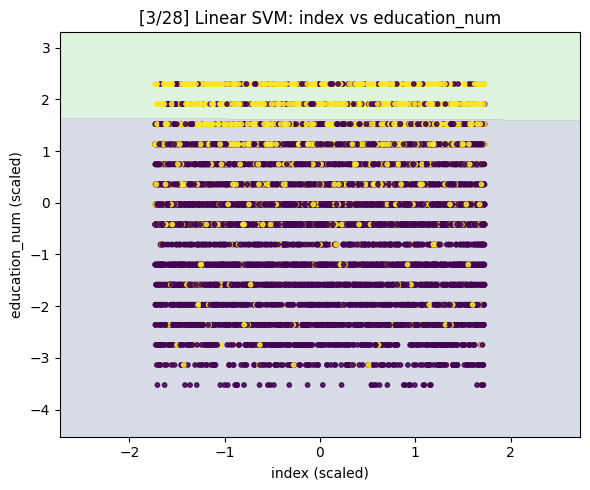

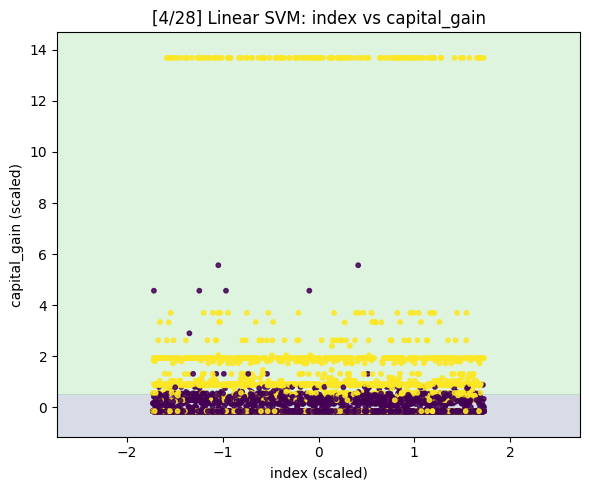

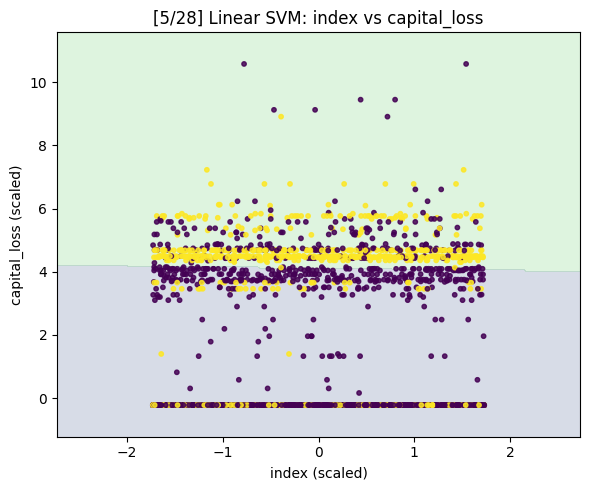

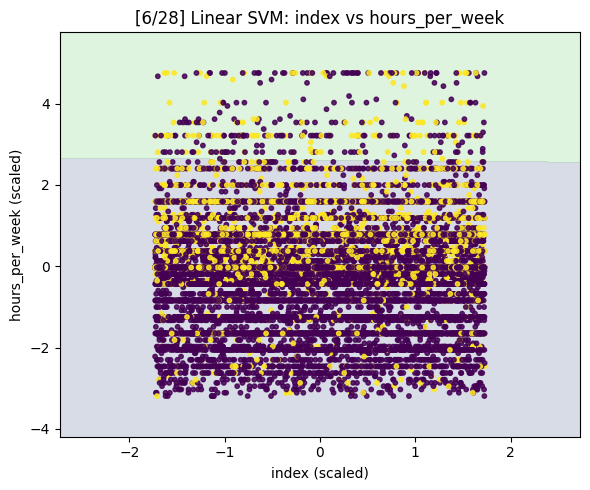

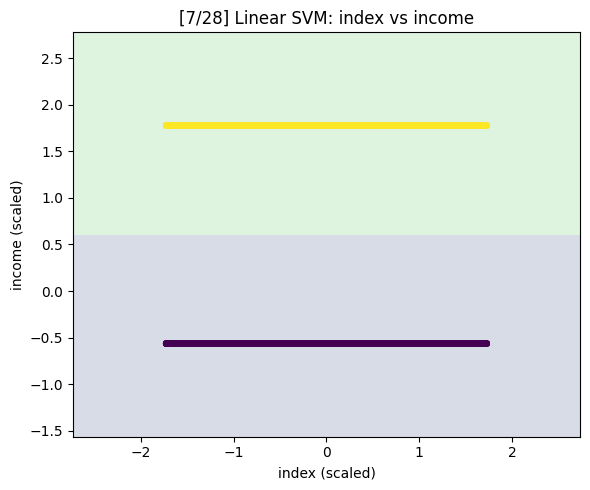

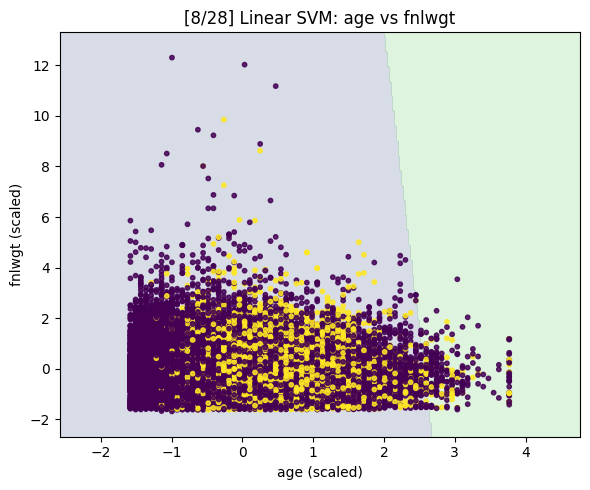

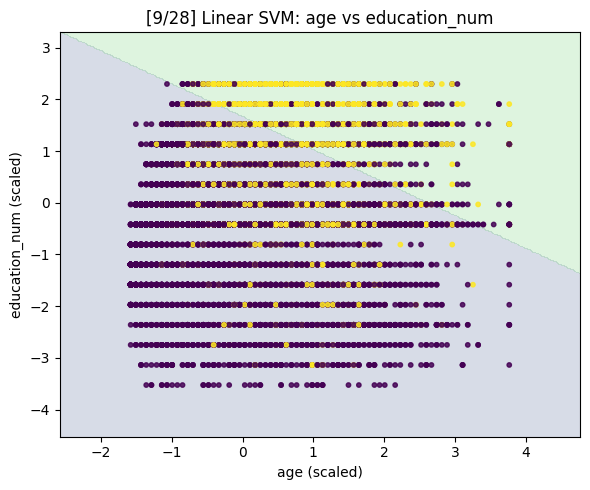

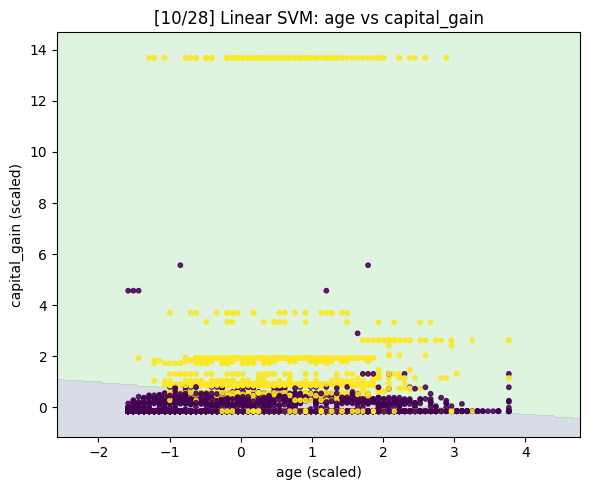

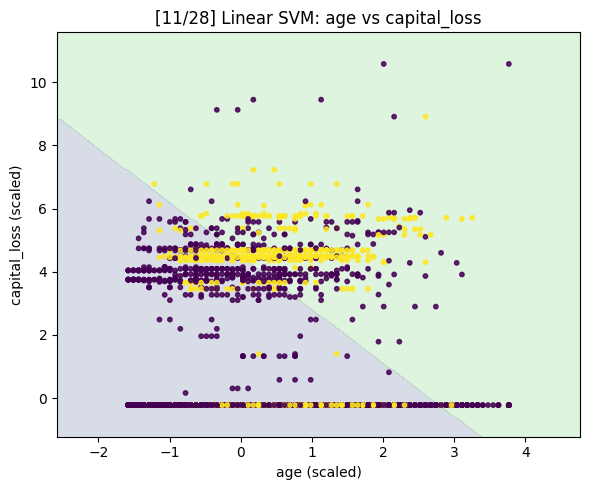

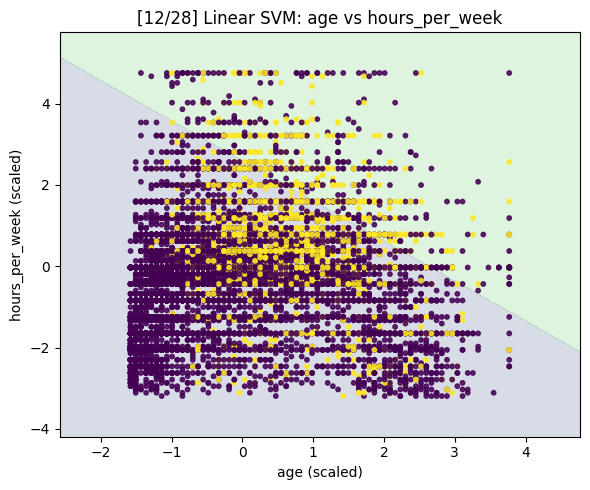

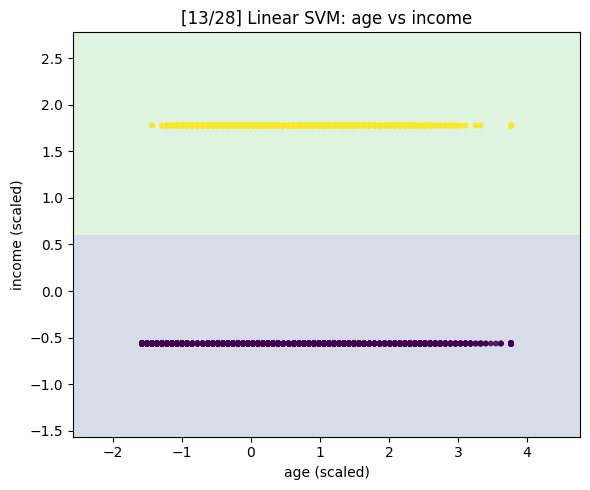

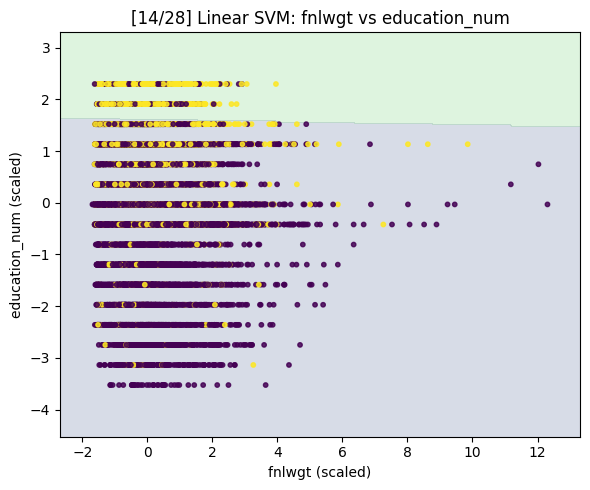

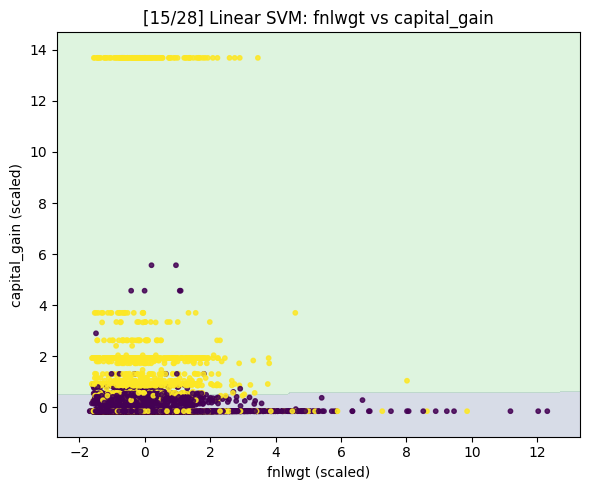

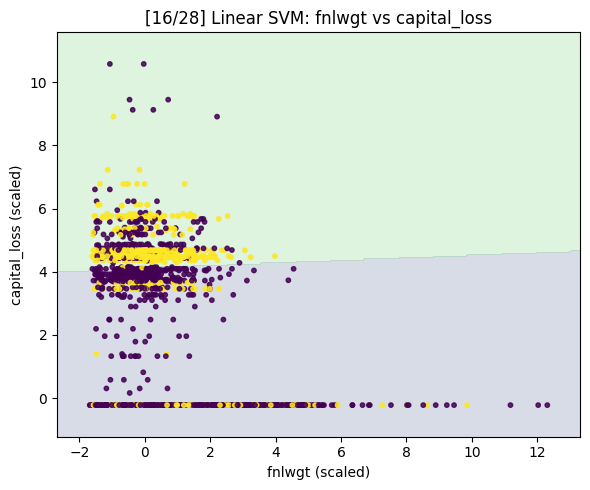

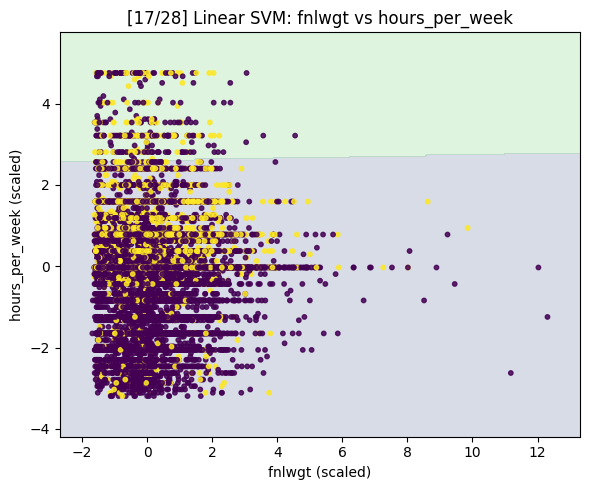

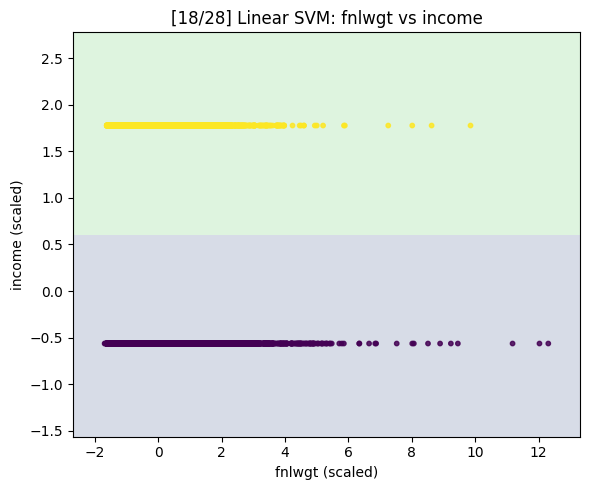

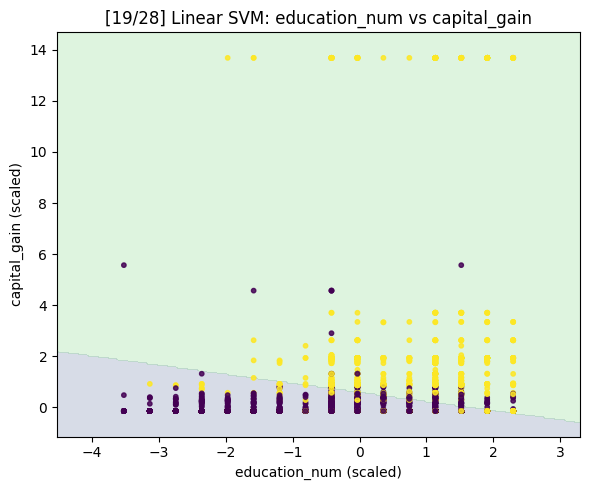

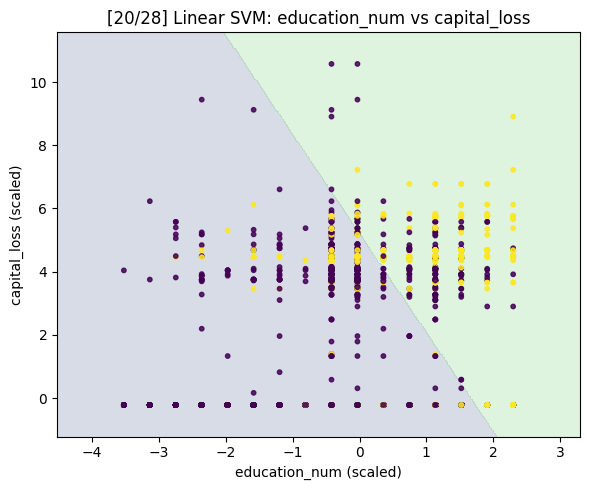

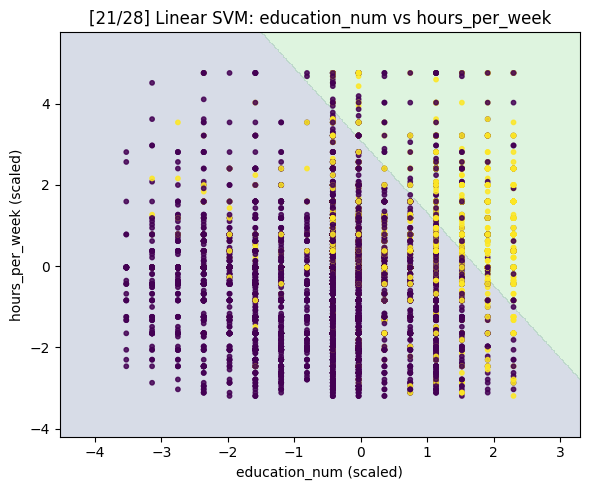

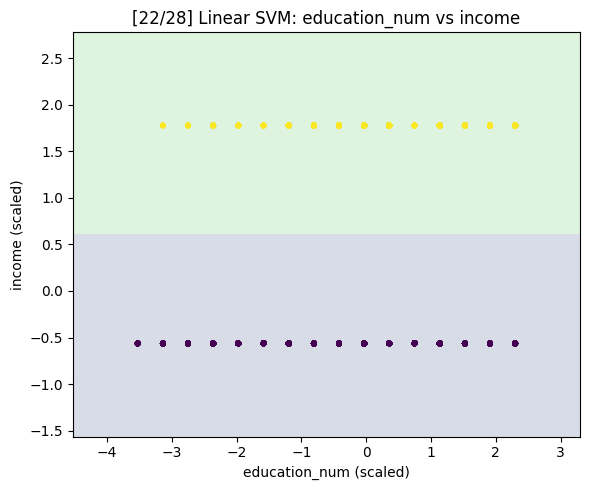

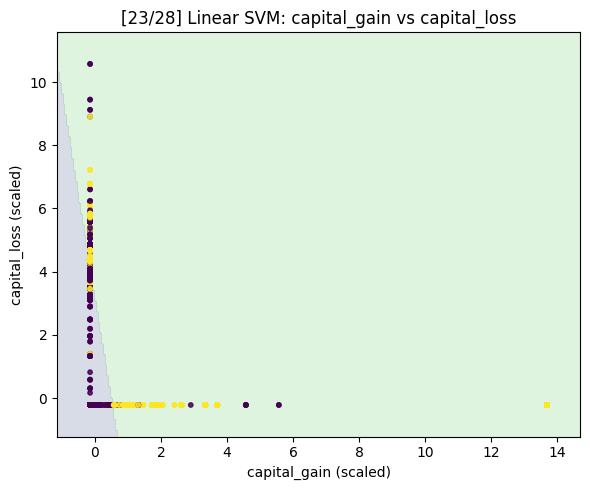

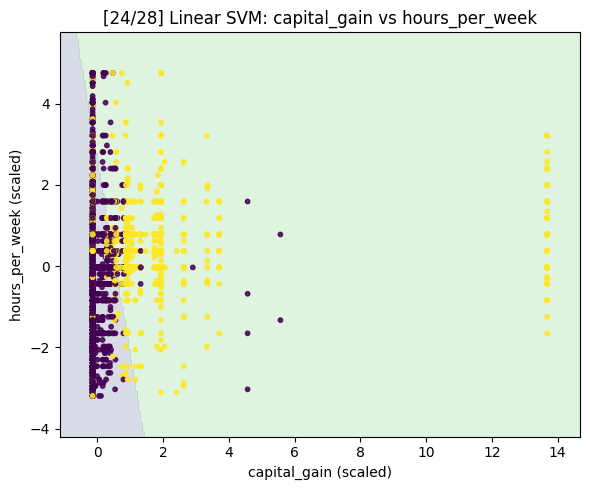

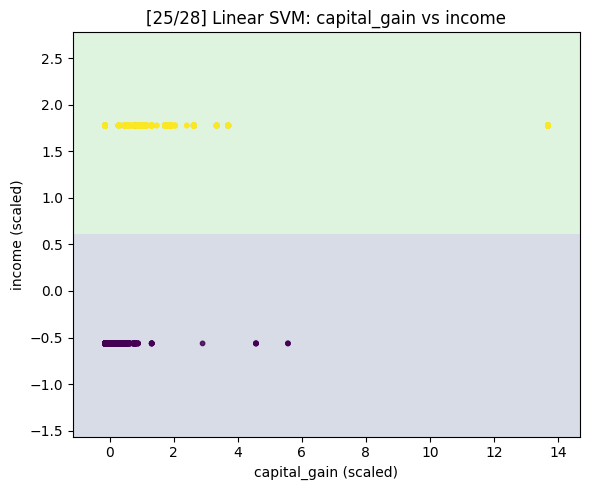

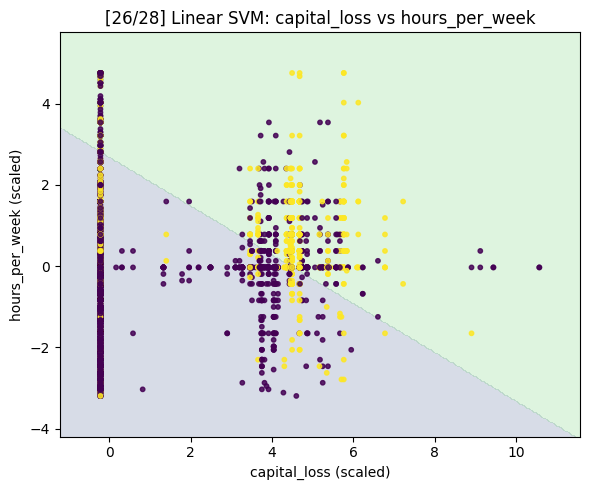

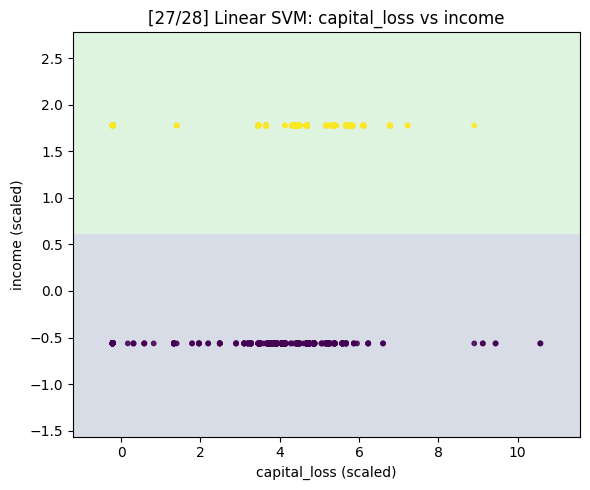

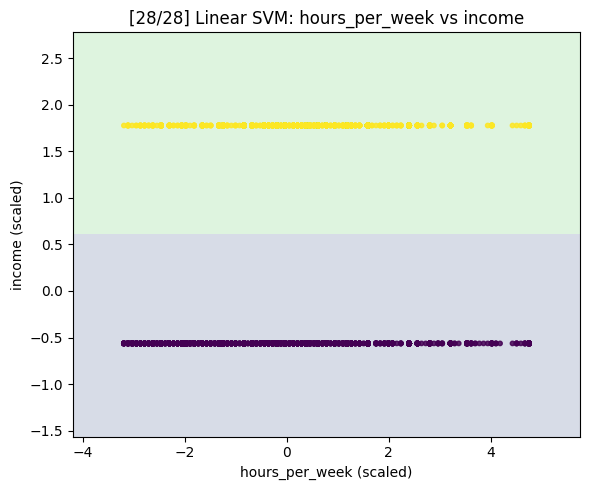

In [53]:
plot_svm_all_pairs(train_df, y_train,
                   C=best_svm_C if "best_svm_C" in globals() else 1.0,
                   save_dir=None,                 # set a folder to save PNGs
                   save_pdf_path=None,            # or set a path to save one PDF
                   max_pairs=None)                # or limit to a subset
